Autor: Esteban Suárez Calvo

In [1]:
import logging
import os
from textwrap import dedent
from time import time
from typing import Optional

from dotenv import load_dotenv
from qiskit import ClassicalRegister, QuantumCircuit, transpile
from qiskit.providers import BackendV2 as Backend
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Batch, Estimator, QiskitRuntimeService, Sampler
from qiskit_ibm_runtime.fake_provider import FakeTorino

# Práctica Final

## Creación del circuito

Para el circuito, optamos por utilizar el circuito del algoritmo de Bernstein-Vazirani.

Este algoritmo permite adivinar una cadena secreta $s$ de $n$ bits en una sola consulta al oráculo (función $f(x)$), mientras que de manera clásica serían necesarias $n$ consultas.

Primero de todo, implementamos una función que, dado un oráculo, devuelve un circuito con dicho oráculo.

In [2]:
def get_bernstein_vazirani_circuit(oracle: QuantumCircuit) -> QuantumCircuit:
    """
    Construye el circuito completo para el algoritmo de Bernstein-Vazirani dado un oráculo.

    Args:
        oracle (QuantumCircuit): El oráculo que codifica la cadena secreta.

    Returns:
        QuantumCircuit: El circuito completo listo para ser ejecutado.
    """
    n = oracle.width() - 1  # Número de qubits de entrada (excluyendo el ancilla)

    qc = QuantumCircuit(n + 1)

    # Inicialización del estado:
    # 1. Ponemos el qubit ancilla (el último) en estado |-> para habilitar el 'phase kickback'.
    #    Para ello aplicamos X (pasa a |1>) y luego H (pasa a |->).
    qc.x(n)

    # 2. Aplicamos H a todos los qubits (entradas y ancilla).
    #    Las entradas pasan de |0> a |+> (superposición equiprobable).
    qc.h(range(n + 1))

    qc.barrier()
    qc = qc.compose(oracle)  # Aplicamos el oráculo
    qc.barrier()

    # Interferencia final:
    # Aplicamos H de nuevo a los qubits de entrada para deshacer la superposición
    # y revelar la cadena oculta gracias al kickback de fase.
    qc.h(range(n))

    cr = ClassicalRegister(n, name="meas")
    qc.add_register(cr)
    qc.measure(range(n), range(n))

    return qc

Definimos ahora una función para la que, dada una cadena determinada, devuelve el oráculo correspondiente.

In [3]:
def bernstein_vazirani_oracle(s: str) -> QuantumCircuit:
    """
    Crea un oráculo cuántico para una cadena binaria secreta 's'.

    El oráculo aplica una puerta CNOT entre el qubit i-ésimo y el qubit ancilla
    si el bit i-ésimo de la cadena 's' es 1.
    """
    n = len(s)

    # Invertimos la cadena porque Qiskit utiliza un ordenamiento little-endian (bit menos
    # significativo en q0), mientras que las cadenas suelen leerse big-endian.
    s = s[::-1]

    qc = QuantumCircuit(n + 1)

    for i, s_bit in enumerate(s):
        if s_bit == "1":
            # Si el bit es 1, aplicamos una CNOT con el ancilla como target.
            # Esto implementa la función f(x) = s * x (producto escalar mod 2).
            qc.cx(i, n)
    return qc

Por último, creamos el circuito que utilizaremos para el resto del notebook, el circuito de Bernstein Vazirani para la cadena `1010111011011`.

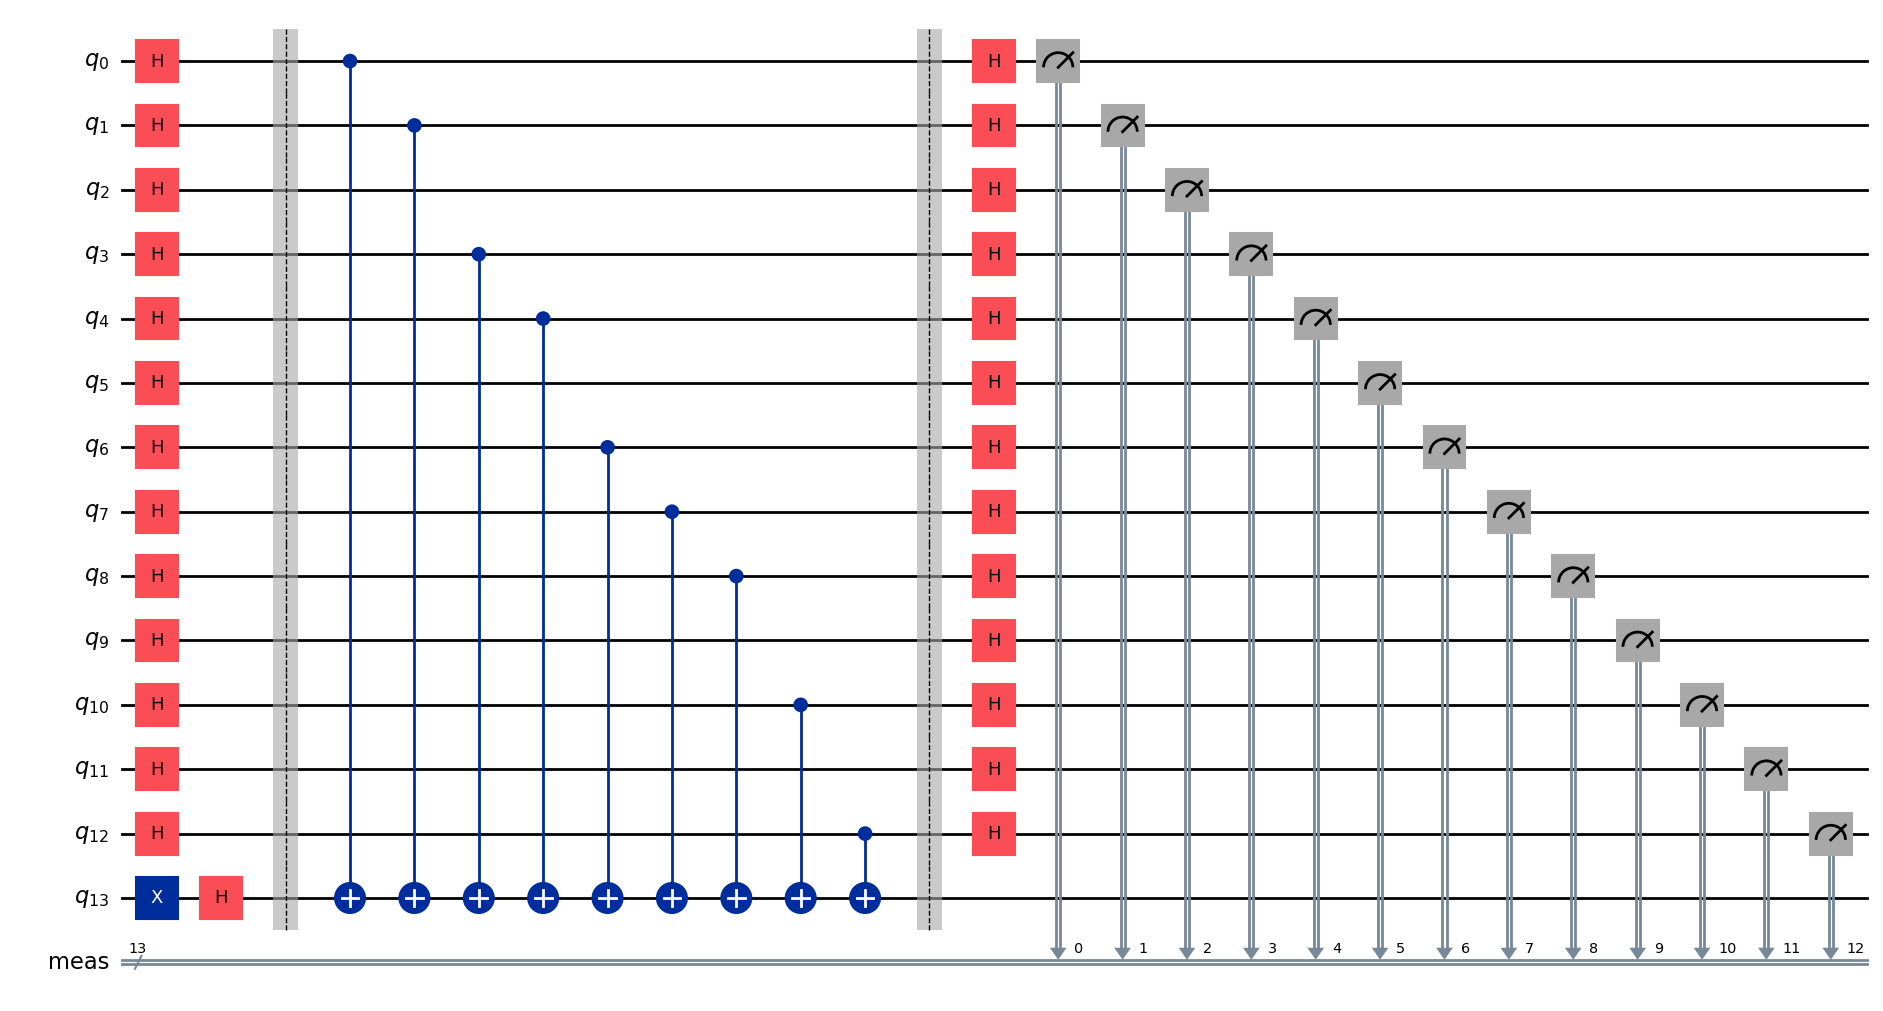

In [4]:
bitstring = "1010111011011"
oracle = bernstein_vazirani_oracle(bitstring)
qc = get_bernstein_vazirani_circuit(oracle)
qc.draw("mpl", fold=-1)

## Obtener la profundidad y el factor unitario

### Profundidad

In [5]:
print(f"La profundidad del circuito es {qc.depth()}")

La profundidad del circuito es 13


A continuación, analizamos por qué la profundidad es 13:

1. Primero se aplican de manera paralela puertas `H` sobre los qubits $q_0...q_{12}$ y la puerta `X` sobre el qubit $q_{11}$. Tras este punto la **profundidad es 1**.
2. Luego se ejecuta la puerta `H` sobre el qubit $q_{13}$. Tras este punto la **profundidad es 2**.
4. Una vez ya hemos pasado la primera barrera, se aplican 9 `CX` sobre el qubit $q_{13}$, las cuales, debido a que se aplican sobre el mismo qubit, no se pueden aplicar de forma paralela. Tras este punto, la **profundidad es 11**.
5. Pasada la segunda barrera, se aplican de forma paralela puertas `H` sobre los qubits $q_0...q_{12}$. Tras este punto, la **profundidad es 12**.
6. Por útimo, se realiza de manera simultánea una medición sobre todos los qubits excepto el último (el ancilla). Tras este punto, la **profundidad es 13**.


### Factor unitario

In [6]:
print(f"El factor unitario es {qc.num_unitary_factors()}")

El factor unitario es 5


Debido a que se produce entrelazamiento entre los qubits $q_0, q_1, q_3, q_4, q_6, q_7, q_8, q_{10}, q_{12}$ y el qubit $q_{13}$ (aquellos correspondientes a los `1` de la cadena), todos estos qubits pasan a formar parte de un mismo "grupo".

Por otro lado, el resto de qubits no realizan ningún tipo de entrelazamiento, por lo que cada uno de ellos forma su propio "grupo".

Por lo tanto, tenemos 5 grupos diferentes, es decir, un factor unitario de 5.

### Ventajas de que estas métricas sean bajas

Mantener estas métricas bajas es crucial en la era NISQ debido a los tiempos limitados de relajación ($T_1$) y desfase ($T_2$) de los qubits.

Una **menor profundidad** reduce el tiempo total de ejecución, disminuyendo la probabilidad de que los qubits sufran decoherencia antes de la medición. Además, también reduce el error acumulado que introducen las puertas.

Un **menor factor unitario** indica que el número de qubits no entrelazados es muy bajo, por lo que estamos aprovechando el paralelismo cuántico y la interferencia.

## Simular el comportamiento ideal

Utilizaremos `qiskit-aer` para realizar las simulaciones ideales.

### `Sampler`

`Sampler` se utiliza para obtener una distribución de probabilidad de los resultados de la medición.

Primero de todo, definimos una función para poder samplear un circuito cualquiera sobre un backend arbitrario.

In [7]:
def sample_circuit(qc: QuantumCircuit, backend: Backend, nshots: int = 1000):
    """
    Ejecuta un circuito cuántico en un backend dado y muestra los resultados.

    Args:
        qc (QuantumCircuit): El circuito a ejecutar.
        backend (Backend): El backend donde se ejecutará.
        nshots (int, optional): Número de repeticiones (shots). Por defecto 1000.
    """
    transpiled_circuit = transpile(qc, backend)

    print("Circuito transpilado:")
    display(transpiled_circuit.draw("mpl", scale=0.5))
    sampler = Sampler(backend)

    job = sampler.run([transpiled_circuit], shots=nshots)
    print(f"Job ID: {job.job_id()}\n")

    result = job.result()
    counts = result[0].data.meas.get_counts()

    display_probabilities(counts)


def display_probabilities(counts: dict[str, int]) -> None:
    """
    Calcula y muestra las probabilidades de los resultados obtenidos, comparándolos
    con la cadena esperada 'bitstring' (variable global).

    Args:
        counts (dict[str, int]): Diccionario con los conteos de cada estado medido.
    """
    total_shots = sum(counts.values())
    probabilities = {k: v / total_shots for k, v in counts.items()}

    most_common_bitstring = max(counts, key=counts.get)
    most_common_prob = counts[most_common_bitstring] / total_shots * 100

    print(
        f"La cadena que más veces obtenemos es {most_common_bitstring}, con un {most_common_prob:.2f}% de probabilidad"
    )
    if most_common_bitstring == bitstring:
        print("La cadena obtenida es correcta")
    else:
        print("La cadena obtenida es incorrecta")

    display(plot_histogram(probabilities))

Con dicha función ya definida, sampleamos nuestro circuito:

Circuito transpilado:


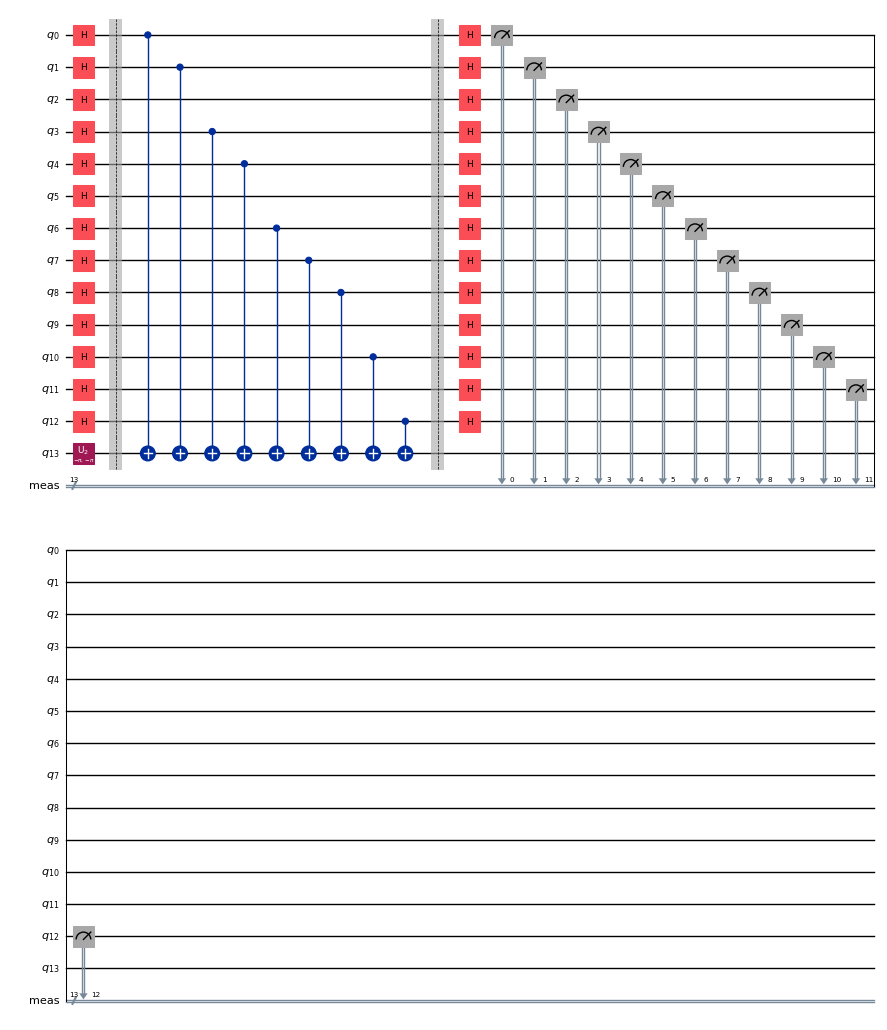

Job ID: ed59f70c-49e6-4557-a3fc-b6ad98ae2844

La cadena que más veces obtenemos es 1010111011011, con un 100.00% de probabilidad
La cadena obtenida es correcta


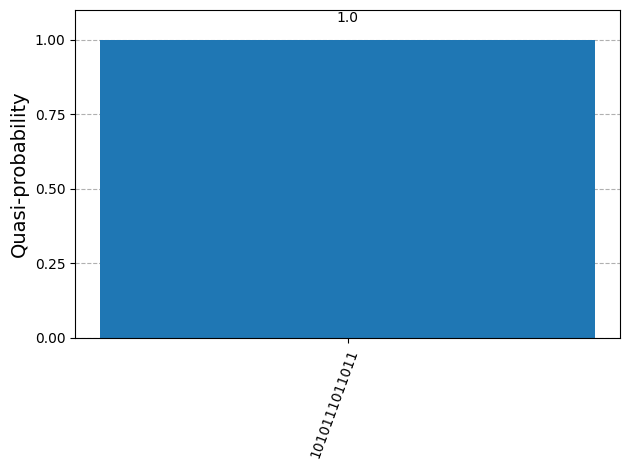

In [8]:
sample_circuit(qc, AerSimulator())

Vemos que, el resultado obtenido se corresponde con el esperado, únicamente se mide la cadena que anteriormente hemos introducido a la función para obtener el oráculo.

### `Estimator`

Sí que sería posible utilizar `Estimator`, pero el enfoque de esta primitiva es diferente. Mientras que `Sampler` nos devuelve un diccionario con los resultados obtenidos (counts), `Estimator` está diseñado para calcular el valor observado de un observable.

Para el circuito que estamos utilizando, el algoritmo de Bernstein-Vazirani, no tiene sentido utilizar el `Estimator`, ya que lo que queremos es obtener los `0` y `1` de la salida para reconstruir dicha cadena. Por lo tanto `Estimator` devolvería un valor promedio que no serviría para este problema específico.

Sin embargo, en el caso de que tuviera sentido utilizar `Estimator`, deberíamos de añadir un input a mayores, el observable sobre el que queremos realizar la medición.

## Simular con un fake provider

Circuito transpilado:


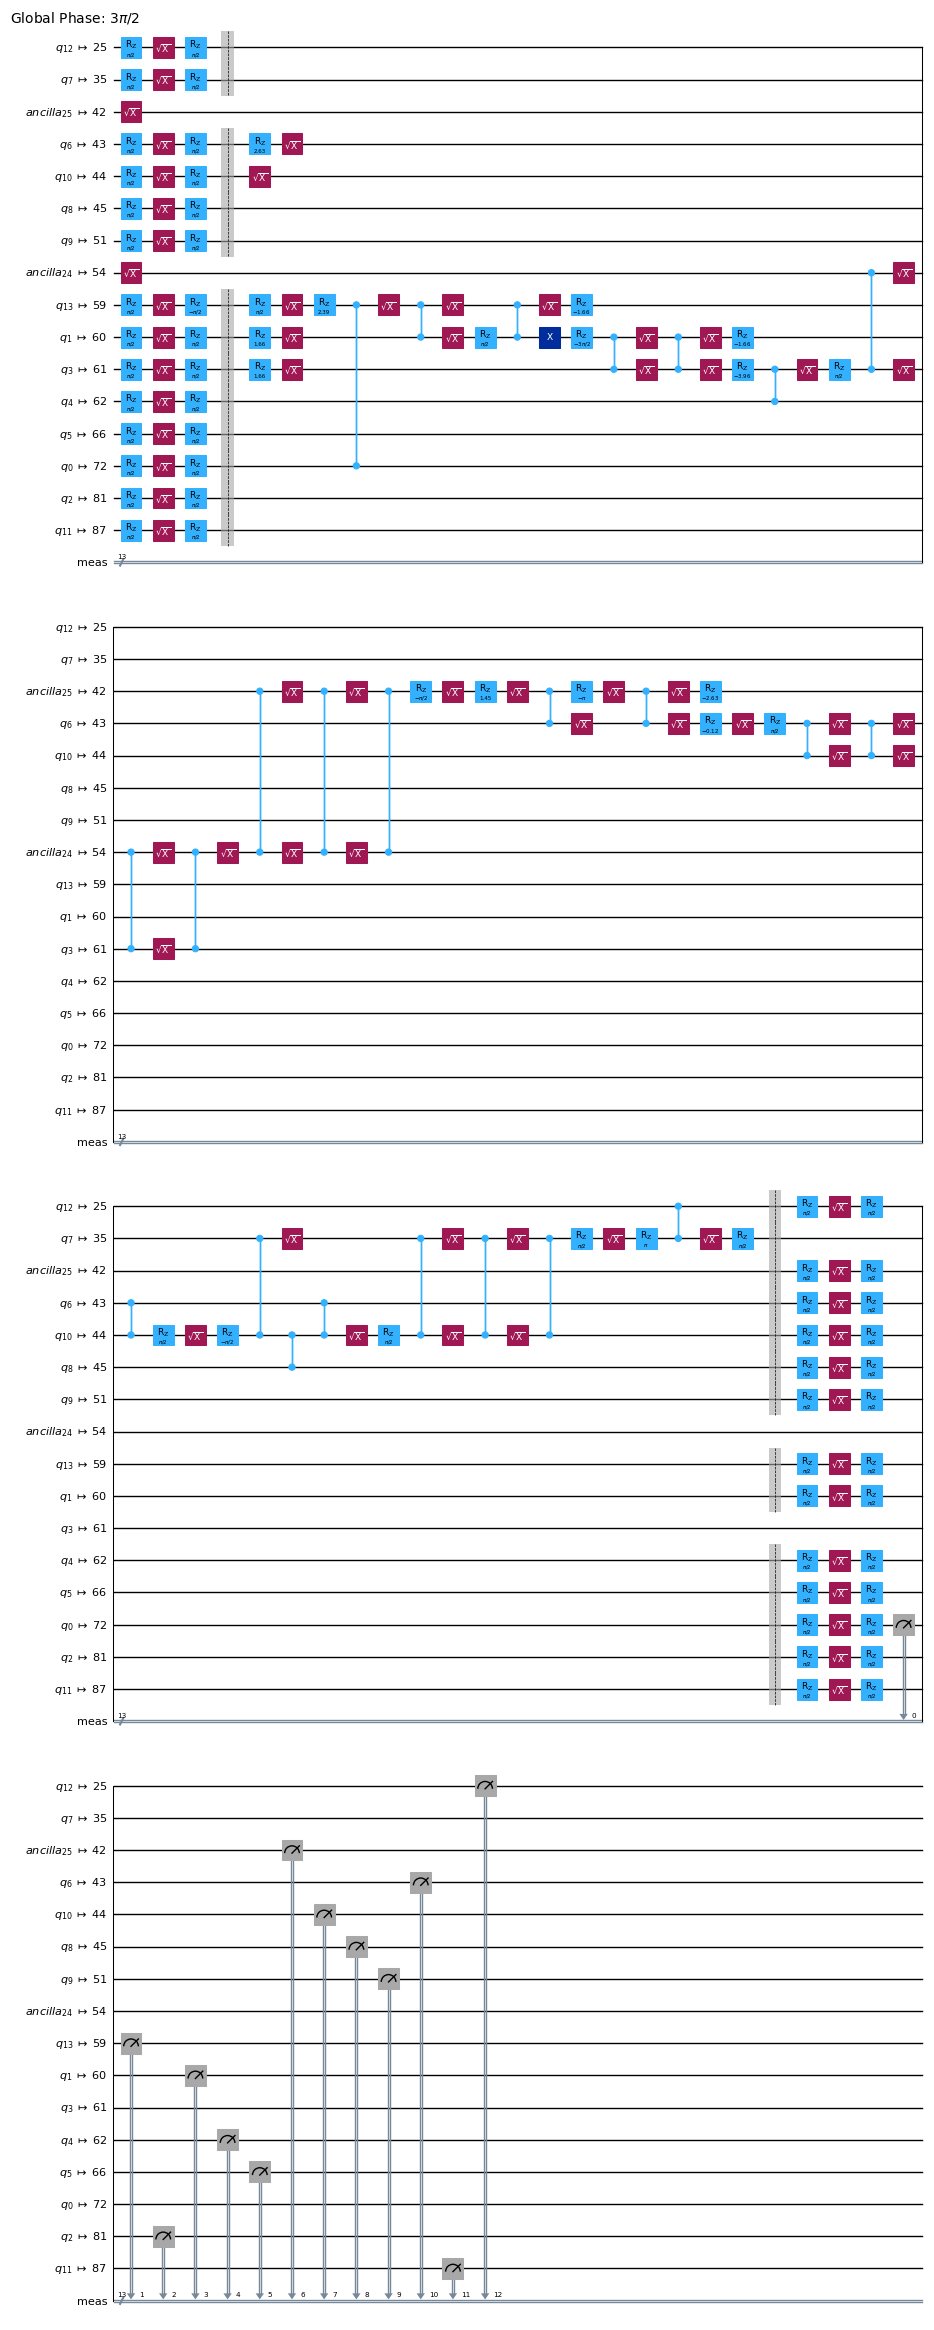

Job ID: 73658325-5852-40c4-b9ae-d4d472ae7215

La cadena que más veces obtenemos es 1010111011011, con un 59.50% de probabilidad
La cadena obtenida es correcta


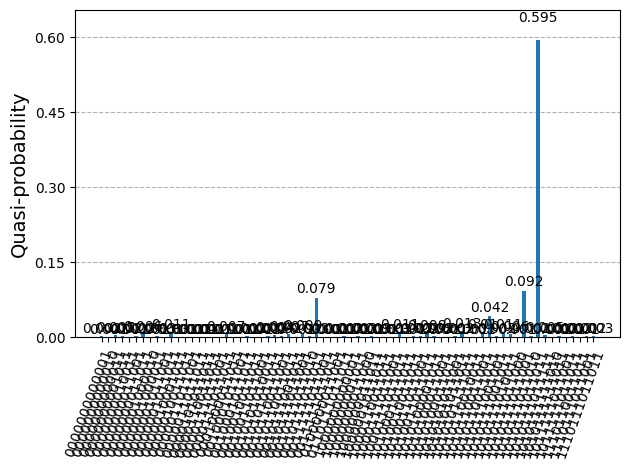

In [9]:
sample_circuit(qc, FakeTorino())

Hemos simulado el circuito utilizando un fake provider, en concreto, `FakeTorino`, el cual incorpora un modelo de ruido basado en el ordenador real `IBM Torino`.

A diferencia del caso ideal, el histograma muestra cierto ruido de fondo. La cadena correcta ya no tiene una probabilidad del 100%, sino que aparecen otros estados con probabilidades no nulas. Esto se debe a 3 factores físicos modelados:

- Errores de lectura.
- Errores de puerta.
- Decoherencia.

### Simular en 2 fake providers distintos

En el caso hipotético de realizar la simulación en 2 fake providers distintos, es muy poco probable que obtengamos los mismos resultados en las 2 ejecuciones.

Esto se debe a diferentes factores:
- Si los fake providers son diferentes, entonces cada uno utiliza un **modelo de ruido distinto**, motivo por el cual, dependiendo de que tan diferentes sean estos modelos de ruido, los resultados serían más o menos parecidos.
- La **tipología** de la QPU puede ser diferente. Si uno de los dispositivos requiere un mayor número de puertas `SWAP` (menor conectividad), entonces tendrá más profundidad, lo que incrementa el ruido.

## Ejecutar en un ordenador cuántico IBM real

### Redefinir `sample_circuit`

Redefinimos la función `sample_circuit`, de nuevo, este paso no es estrictamente necesario, pero nos simplificará el código en este apartado en el siguiente.

In [10]:
def sample_circuit(
    qc: QuantumCircuit,
    backend: Backend,
    sampler: Optional[Sampler] = None,
    nshots: int = 1000,
    optimization_level: int = 1,
) -> None:
    """
    Versión extendida de sample_circuit que permite inyectar un Sampler y controlar el
    nivel de optimización.

    Args:
        qc (QuantumCircuit): El circuito a ejecutar.
        backend (Backend): El backend donde se ejecutará.
        sampler (Optional[Sampler], optional): Instancia de Sampler a reutilizar (útil
            para sesiones/batch).
        nshots (int, optional): Número de shots. Por defecto 1000.
        optimization_level (int, optional): Nivel de optimización del transpiler (0-3).
            Por defecto 1.
    """
    if not sampler:
        sampler = Sampler(backend)

    transpiled_circuit = _do_transpilation(
        qc, backend, optimization_level=optimization_level
    )

    print("Circuito transpilado:")
    display(transpiled_circuit.draw("mpl", scale=0.5))

    job = sampler.run([transpiled_circuit], shots=nshots)
    print(f"Job ID: {job.job_id()}\n")

    result = job.result()
    counts = result[0].data.meas.get_counts()

    display_probabilities(counts)
    print_actual_QR_usage(job)


def _do_transpilation(
    circuits: QuantumCircuit,
    backend: Backend,
    optimization_level: int = 1,
) -> QuantumCircuit:
    """
    Función auxiliar para transpilar el circuito midiendo el tiempo y mostrando
    estadísticas.

    Args:
        circuits (QuantumCircuit): Circuito a transpilar.
        backend (Backend): Backend objetivo.
        optimization_level (int): Nivel de optimización (0-3).

    Returns:
        QuantumCircuit: El circuito transpilado.
    """
    start = time()
    transpiled_qc = transpile(circuits, backend, optimization_level=optimization_level)
    transpilation_time = time() - start

    print(
        dedent(
            f"""
            Circuito transpilado para el backend {backend.name}:
            > Nivel de optimización: {optimization_level}
            > Profundidad: {transpiled_qc.depth()}
            > Número de puertas: {transpiled_qc.count_ops()}
            > Tiempo de transpilación: {transpilation_time:.5f}
            """
        )
    )

    return transpiled_qc


def print_actual_QR_usage(job):
    """
    Imprime el uso de recursos cuánticos si el trabajo se ejecutó en hardware real.

    Args:
        job: El objeto Job de Qiskit Runtime a inspeccionar.
    """
    # Únicamente los jobs que se corresponden con hardware real tienen el atributo usage
    if not hasattr(job, "usage"):
        return

    usage = job.usage()

    print(f"Uso del hardware cuántico: {usage} segundos")

### Cargar la cuenta de IBM

Procedemos a cargar nuestra cuenta. La clave está almacenada en un fichero `.env`, de manera que podamos compartir el notebook de forma segura, pues no exponemos una clave privada.

También configuramos el logger para que únicamente muestre errores, y no warnings relativos al tipo de plan que tenemos.

In [11]:
logging.getLogger("qiskit_ibm_runtime").setLevel(logging.ERROR)

load_dotenv()
ibm_key = os.getenv("IBM_KEY")
QiskitRuntimeService.save_account(token=ibm_key, overwrite=True)
service = QiskitRuntimeService()

### Ejecución del circuito


Circuito transpilado para el backend ibm_torino:
> Nivel de optimización: 1
> Profundidad: 77
> Número de puertas: OrderedDict({'rz': 74, 'sx': 69, 'cz': 27, 'measure': 13, 'barrier': 2})
> Tiempo de transpilación: 1.36448

Circuito transpilado:


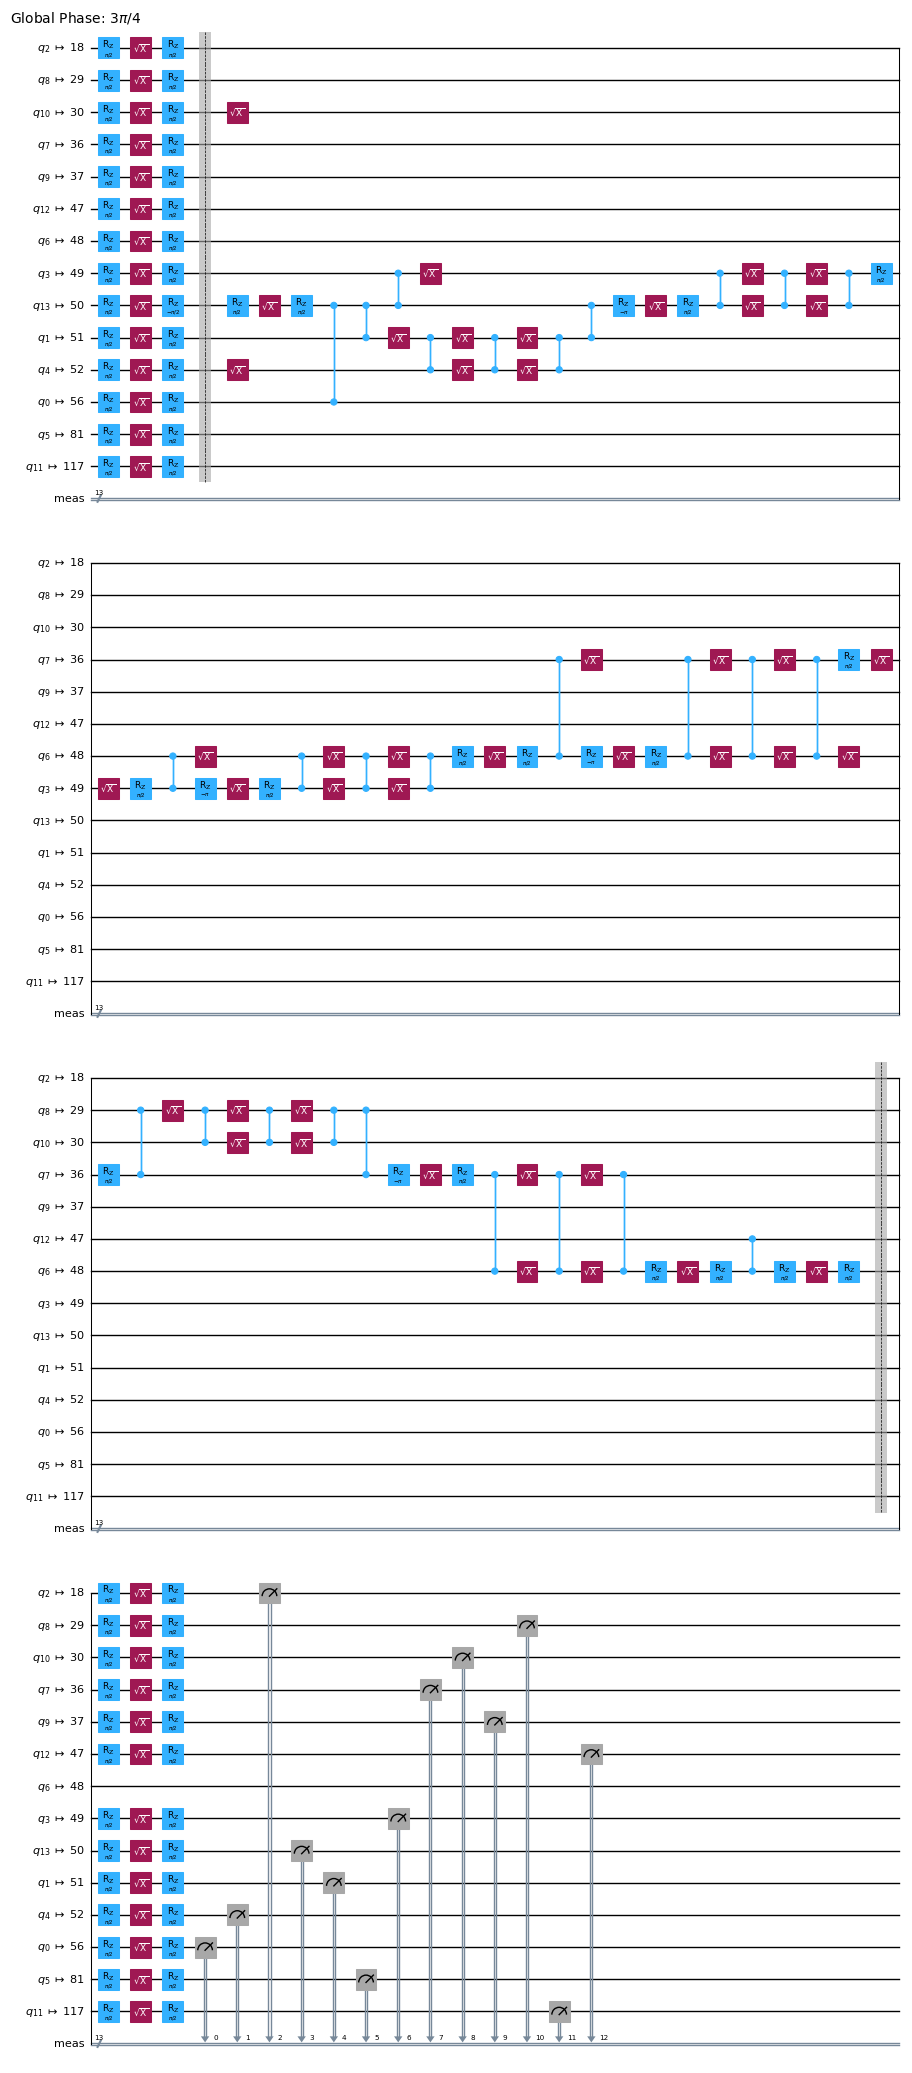

Job ID: d5kdn27853es738dovo0

La cadena que más veces obtenemos es 1010111011011, con un 46.70% de probabilidad
La cadena obtenida es correcta


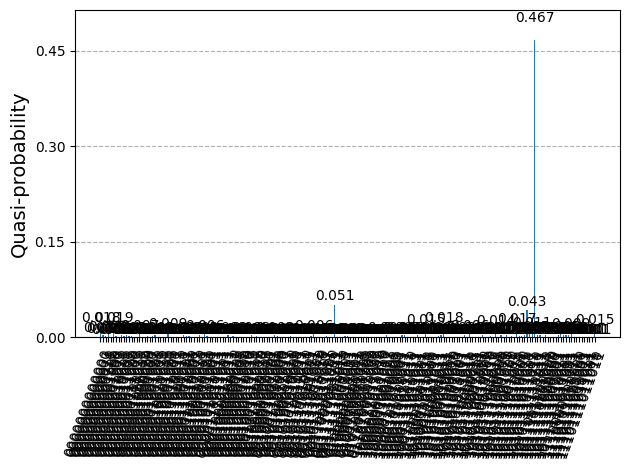

Uso del hardware cuántico: 2 segundos


In [12]:
backend = service.backend("ibm_torino")
sample_circuit(qc, backend)

Como podemos observar, al igual que ocurría con el fake provider, obtenemos el resultado correcto la mayor parte de las veces, aunque, debido al ruido, en bastantes ocasiones, obtenemos resultados incorrectos.

## Ejecutar con los distintos niveles de optimización

Probaremos los distintos niveles de optimización, tanto con un fake provider como con su ordenador real correspondiente. Para ello, primero definiremos la siguiente función:

In [13]:
def execute_all_optimization_levels(qc: QuantumCircuit, backend: Backend) -> None:
    """
    Ejecuta el circuito en el backend dado iterando por los 4 niveles de optimización (0,
    1, 2, 3) dentro de una sesión Batch para optimizar el tiempo de cola.

    Args:
        qc (QuantumCircuit): El circuito a probar.
        backend (Backend): El backend donde ejecutar.
    """
    with Batch(backend=backend) as batch:
        sampler = Sampler(mode=batch)

        for optimization_level in (0, 1, 2, 3):
            print("\n---------------------------------")
            sample_circuit(
                qc, backend, sampler=sampler, optimization_level=optimization_level
            )

### Fake provider


---------------------------------

Circuito transpilado para el backend fake_torino:
> Nivel de optimización: 0
> Profundidad: 178
> Número de puertas: OrderedDict({'sx': 225, 'cz': 99, 'rz': 90, 'measure': 13, 'barrier': 2, 'x': 1})
> Tiempo de transpilación: 0.23870

Circuito transpilado:


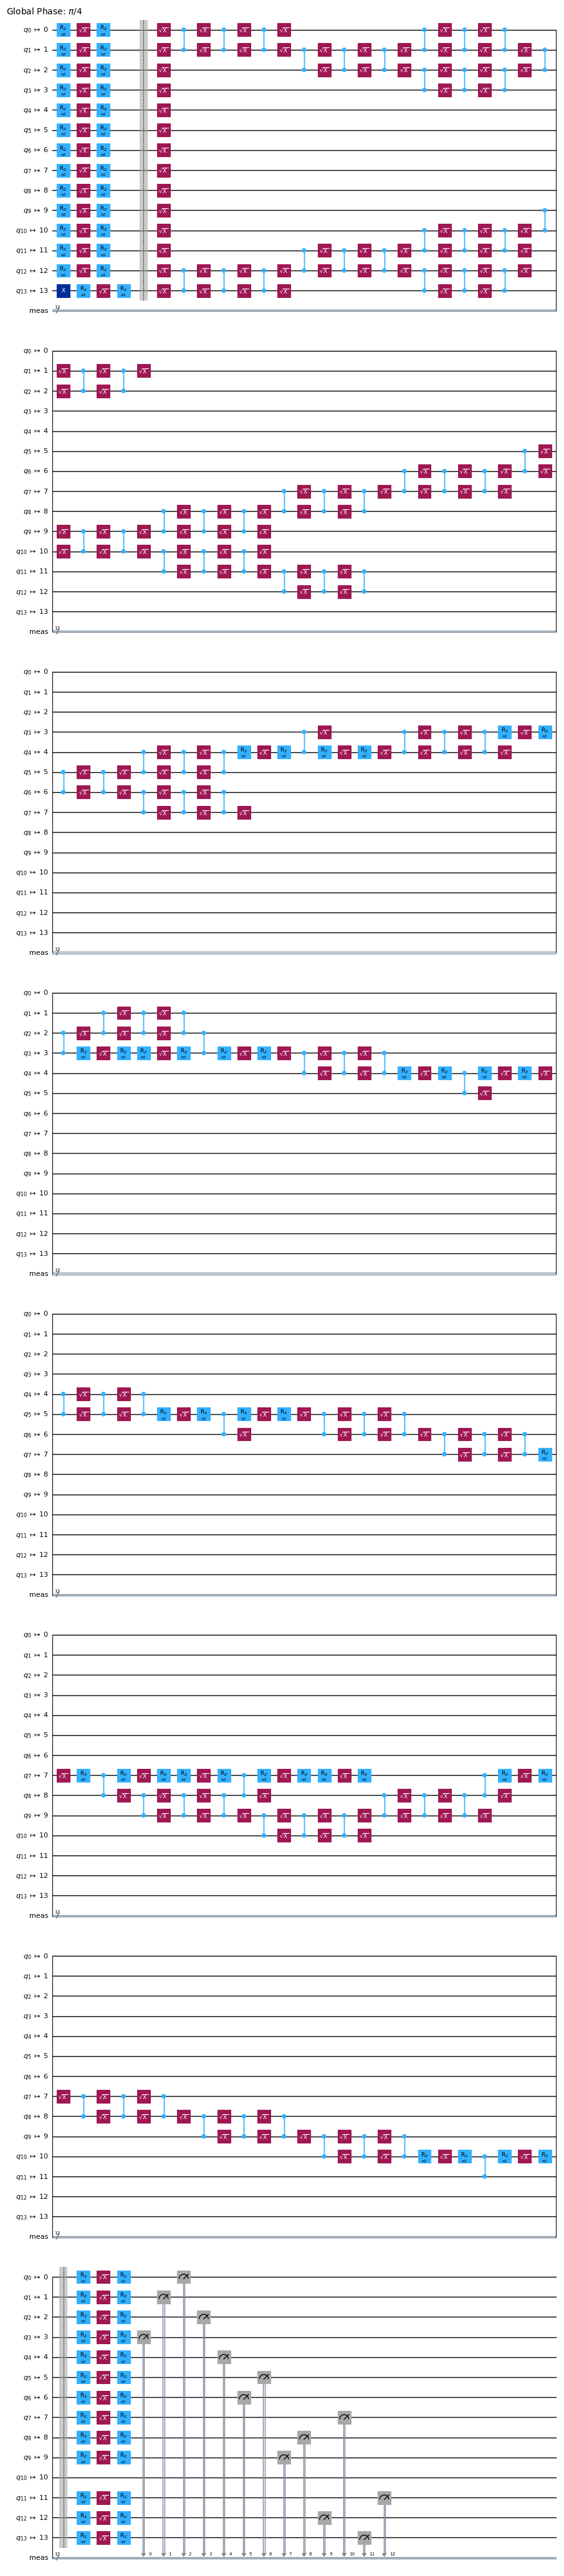

Job ID: 61b2fd70-e59b-40dc-9b1f-69fe70dfc016

La cadena que más veces obtenemos es 1010111011011, con un 30.20% de probabilidad
La cadena obtenida es correcta


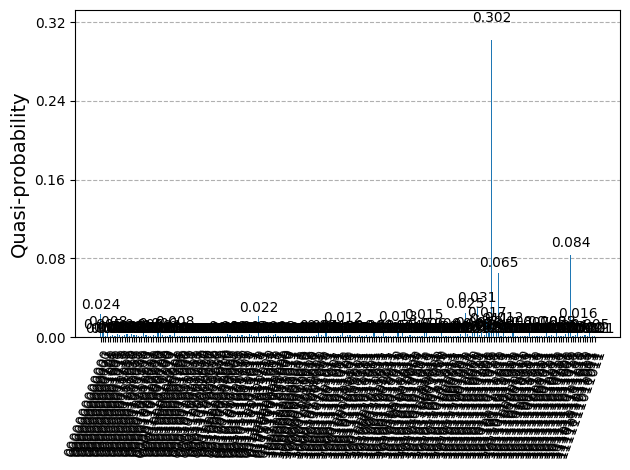

Uso del hardware cuántico: 0 segundos

---------------------------------

Circuito transpilado para el backend fake_torino:
> Nivel de optimización: 1
> Profundidad: 77
> Número de puertas: OrderedDict({'rz': 74, 'sx': 69, 'cz': 27, 'measure': 13, 'barrier': 2})
> Tiempo de transpilación: 0.01748

Circuito transpilado:


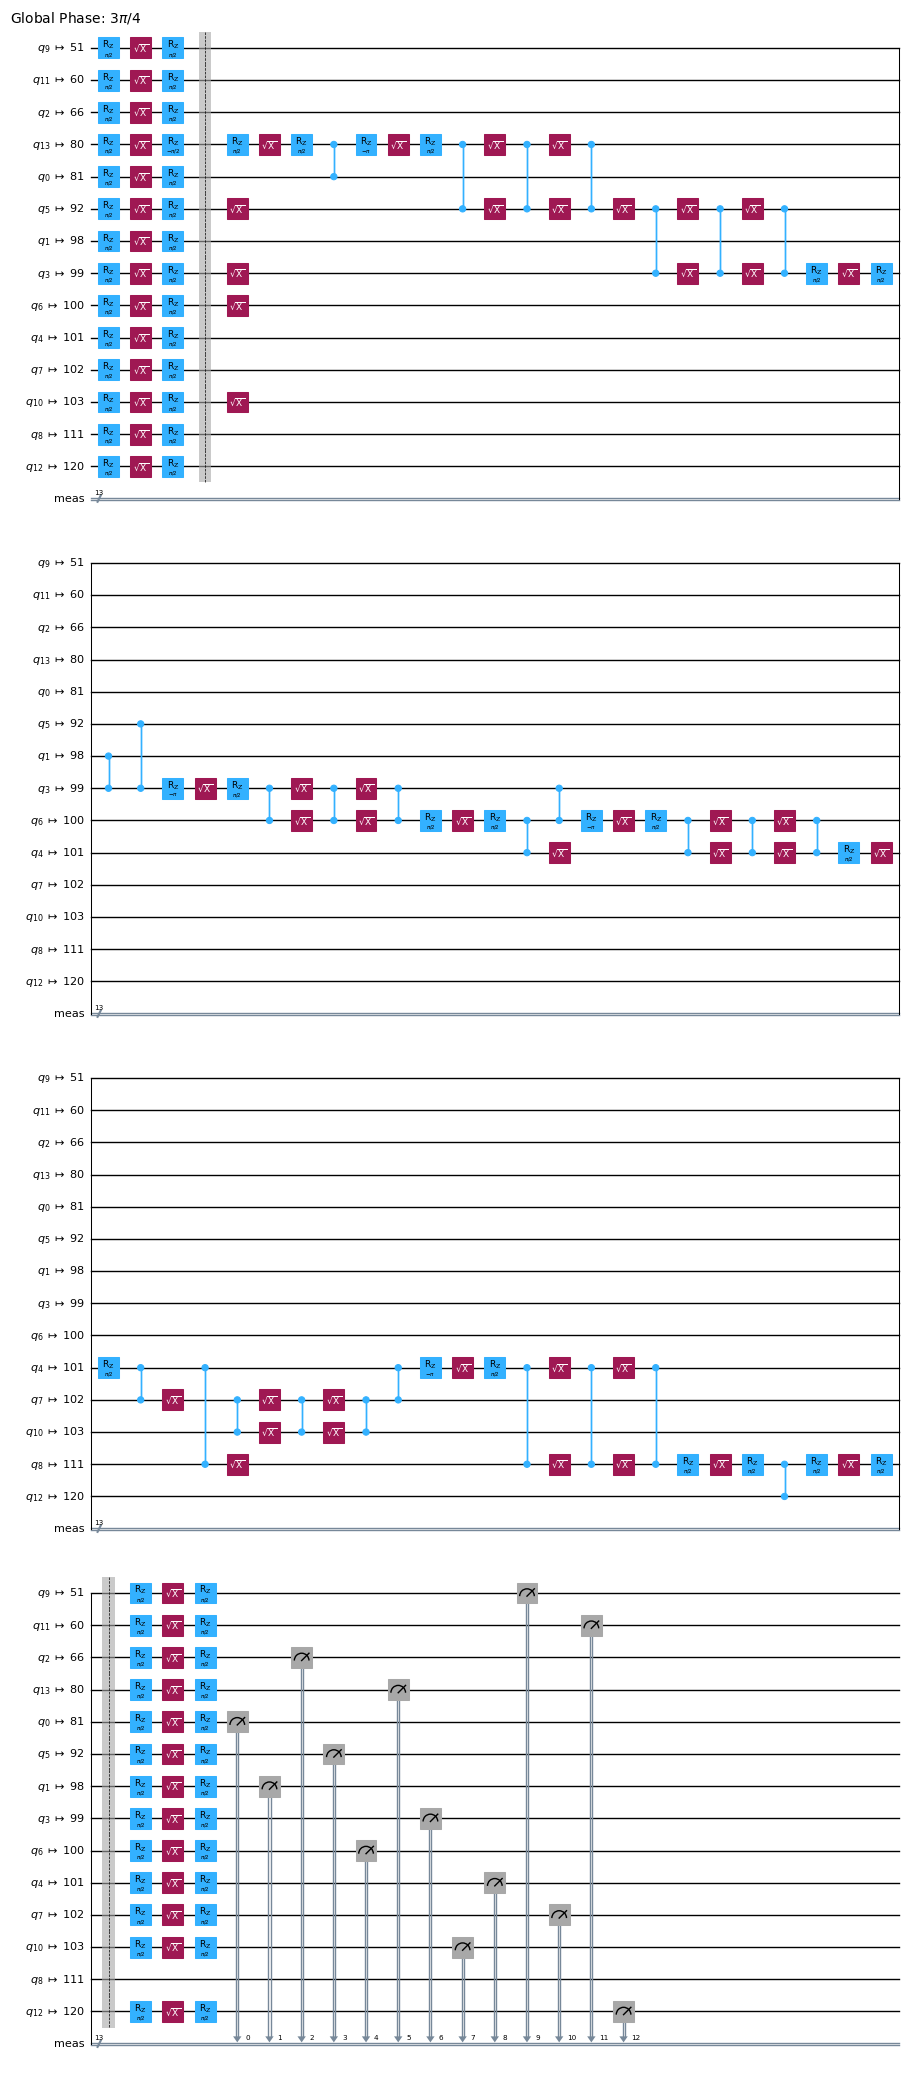

Job ID: 9413af9c-69ea-43bb-8ac9-a04e0f0bf361

La cadena que más veces obtenemos es 1010111011011, con un 67.40% de probabilidad
La cadena obtenida es correcta


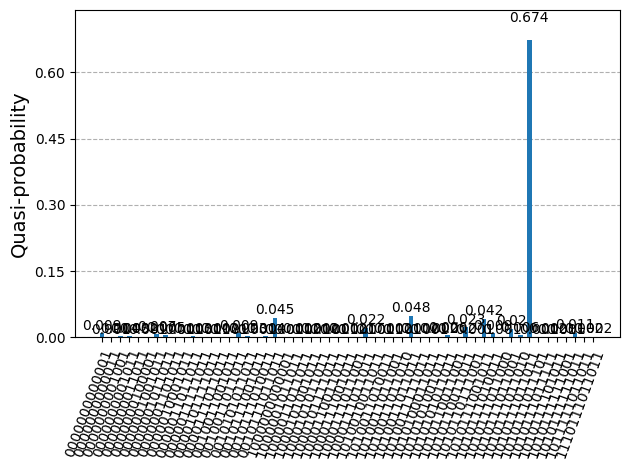

Uso del hardware cuántico: 0 segundos

---------------------------------

Circuito transpilado para el backend fake_torino:
> Nivel de optimización: 2
> Profundidad: 54
> Número de puertas: OrderedDict({'rz': 68, 'sx': 59, 'cz': 24, 'measure': 13, 'barrier': 2, 'x': 1})
> Tiempo de transpilación: 0.01975

Circuito transpilado:


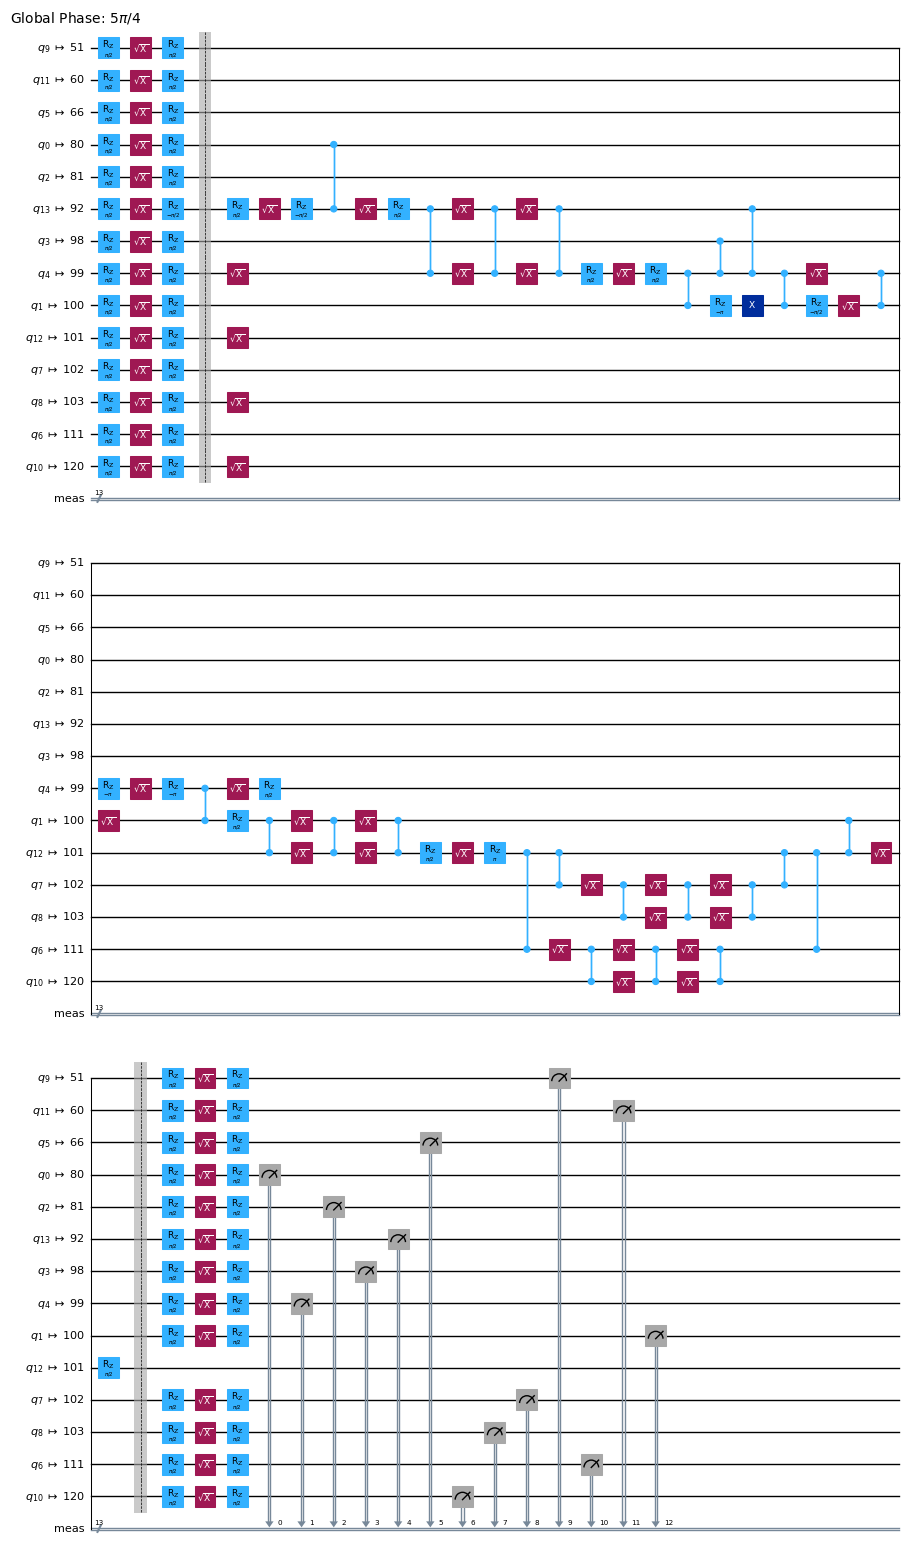

Job ID: 75477e86-644d-453d-9c4d-250e1b0664fd

La cadena que más veces obtenemos es 1010111011011, con un 72.90% de probabilidad
La cadena obtenida es correcta


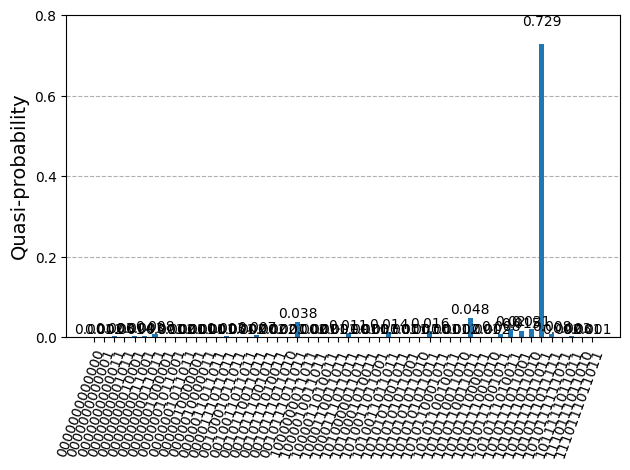

Uso del hardware cuántico: 0 segundos

---------------------------------

Circuito transpilado para el backend fake_torino:
> Nivel de optimización: 3
> Profundidad: 67
> Número de puertas: OrderedDict({'rz': 69, 'sx': 63, 'cz': 24, 'measure': 13, 'barrier': 2})
> Tiempo de transpilación: 0.02029

Circuito transpilado:


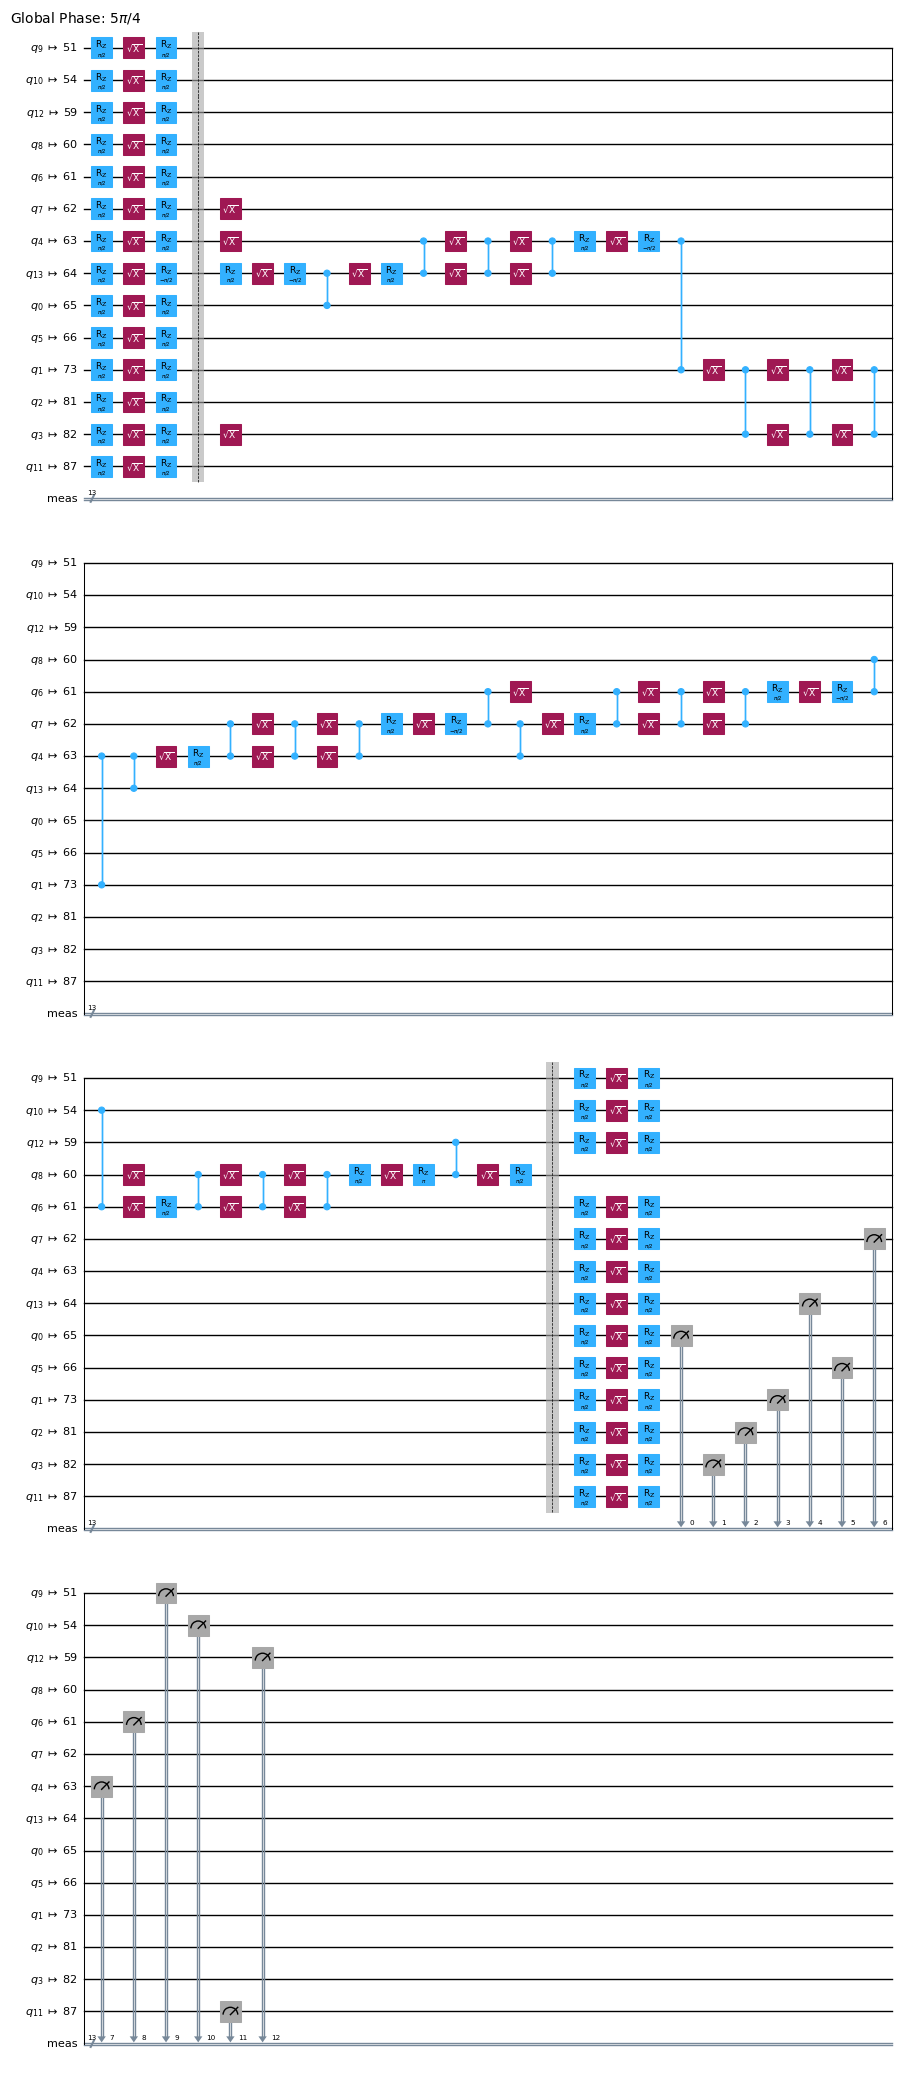

Job ID: d91a8369-68fb-4efa-ab04-aaad79b76e8f

La cadena que más veces obtenemos es 1010111011011, con un 64.60% de probabilidad
La cadena obtenida es correcta


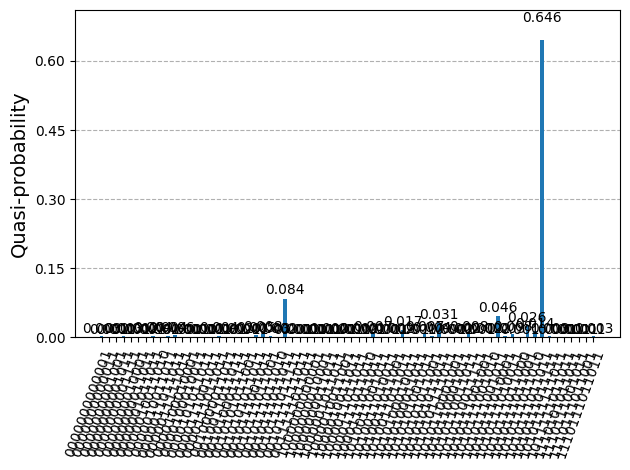

Uso del hardware cuántico: 0 segundos


In [14]:
backend = FakeTorino()
execute_all_optimization_levels(qc, backend)

### Ordenador real


---------------------------------

Circuito transpilado para el backend ibm_torino:
> Nivel de optimización: 0
> Profundidad: 173
> Número de puertas: OrderedDict({'sx': 231, 'cz': 102, 'rz': 90, 'measure': 13, 'barrier': 2, 'x': 1})
> Tiempo de transpilación: 0.77914

Circuito transpilado:


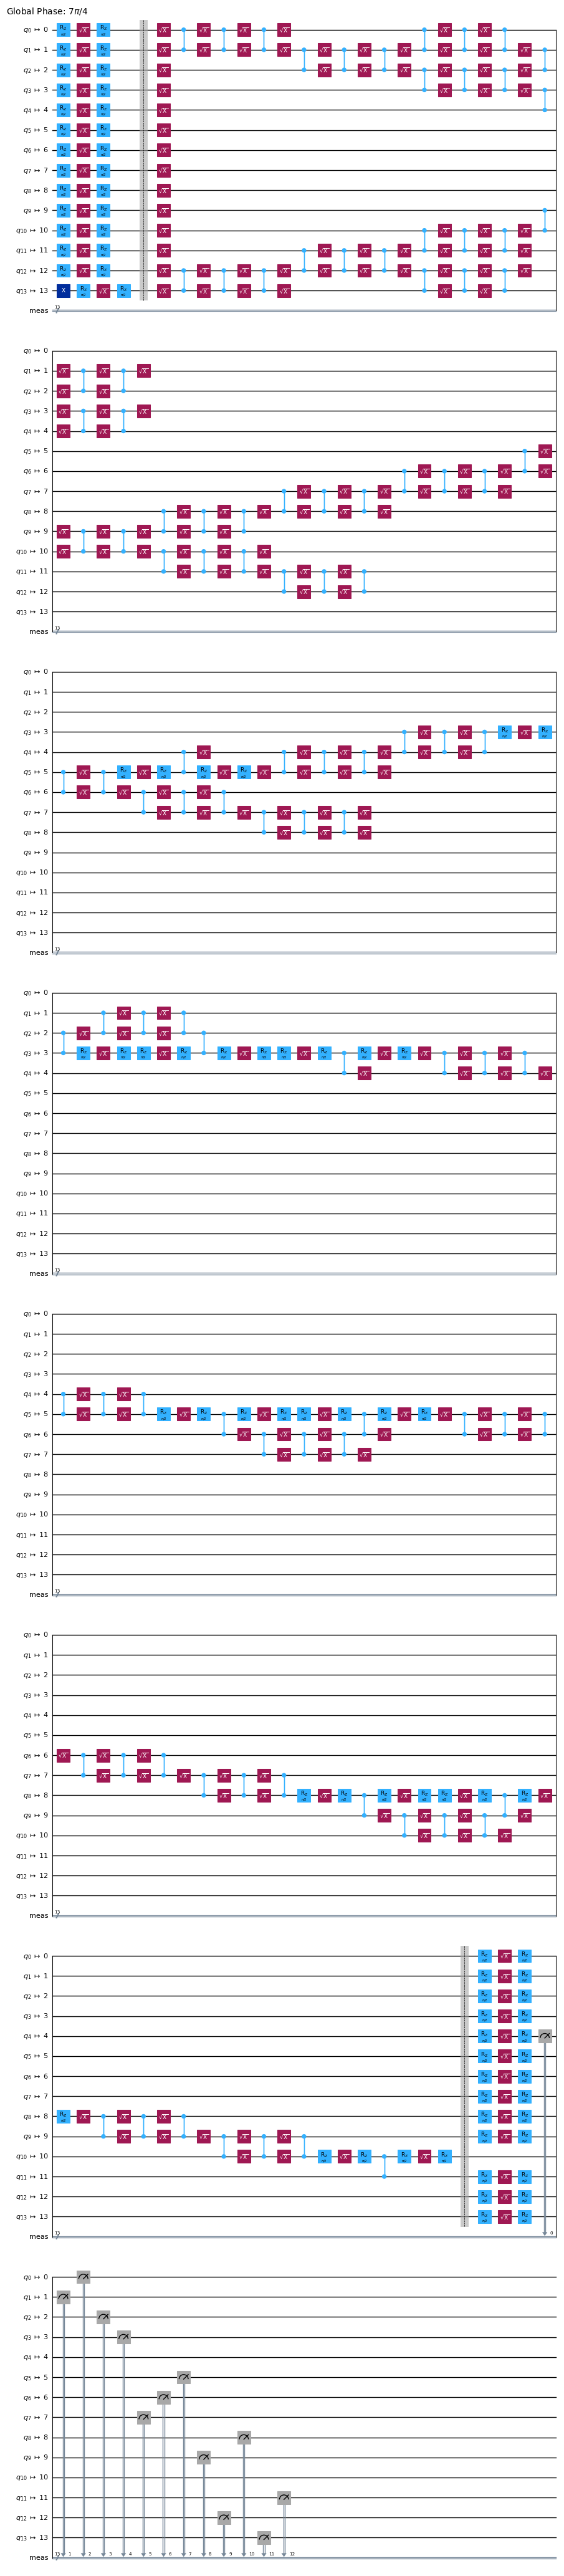

Job ID: d5kdnkavcahs73a1sdp0

La cadena que más veces obtenemos es 1010111011011, con un 15.00% de probabilidad
La cadena obtenida es correcta


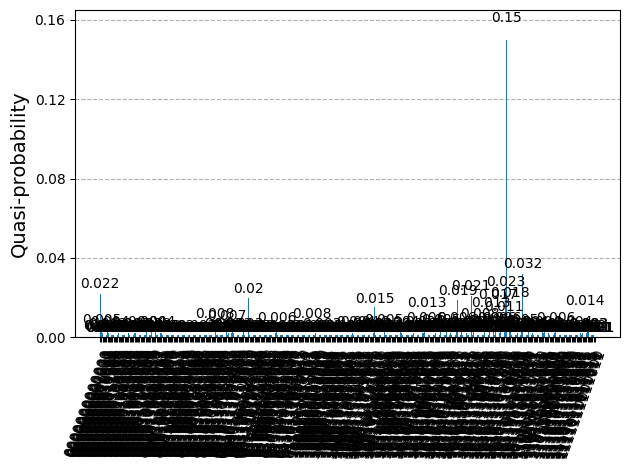

Uso del hardware cuántico: 2 segundos

---------------------------------

Circuito transpilado para el backend ibm_torino:
> Nivel de optimización: 1
> Profundidad: 88
> Número de puertas: OrderedDict({'rz': 82, 'sx': 71, 'cz': 27, 'measure': 13, 'barrier': 2})
> Tiempo de transpilación: 0.04405

Circuito transpilado:


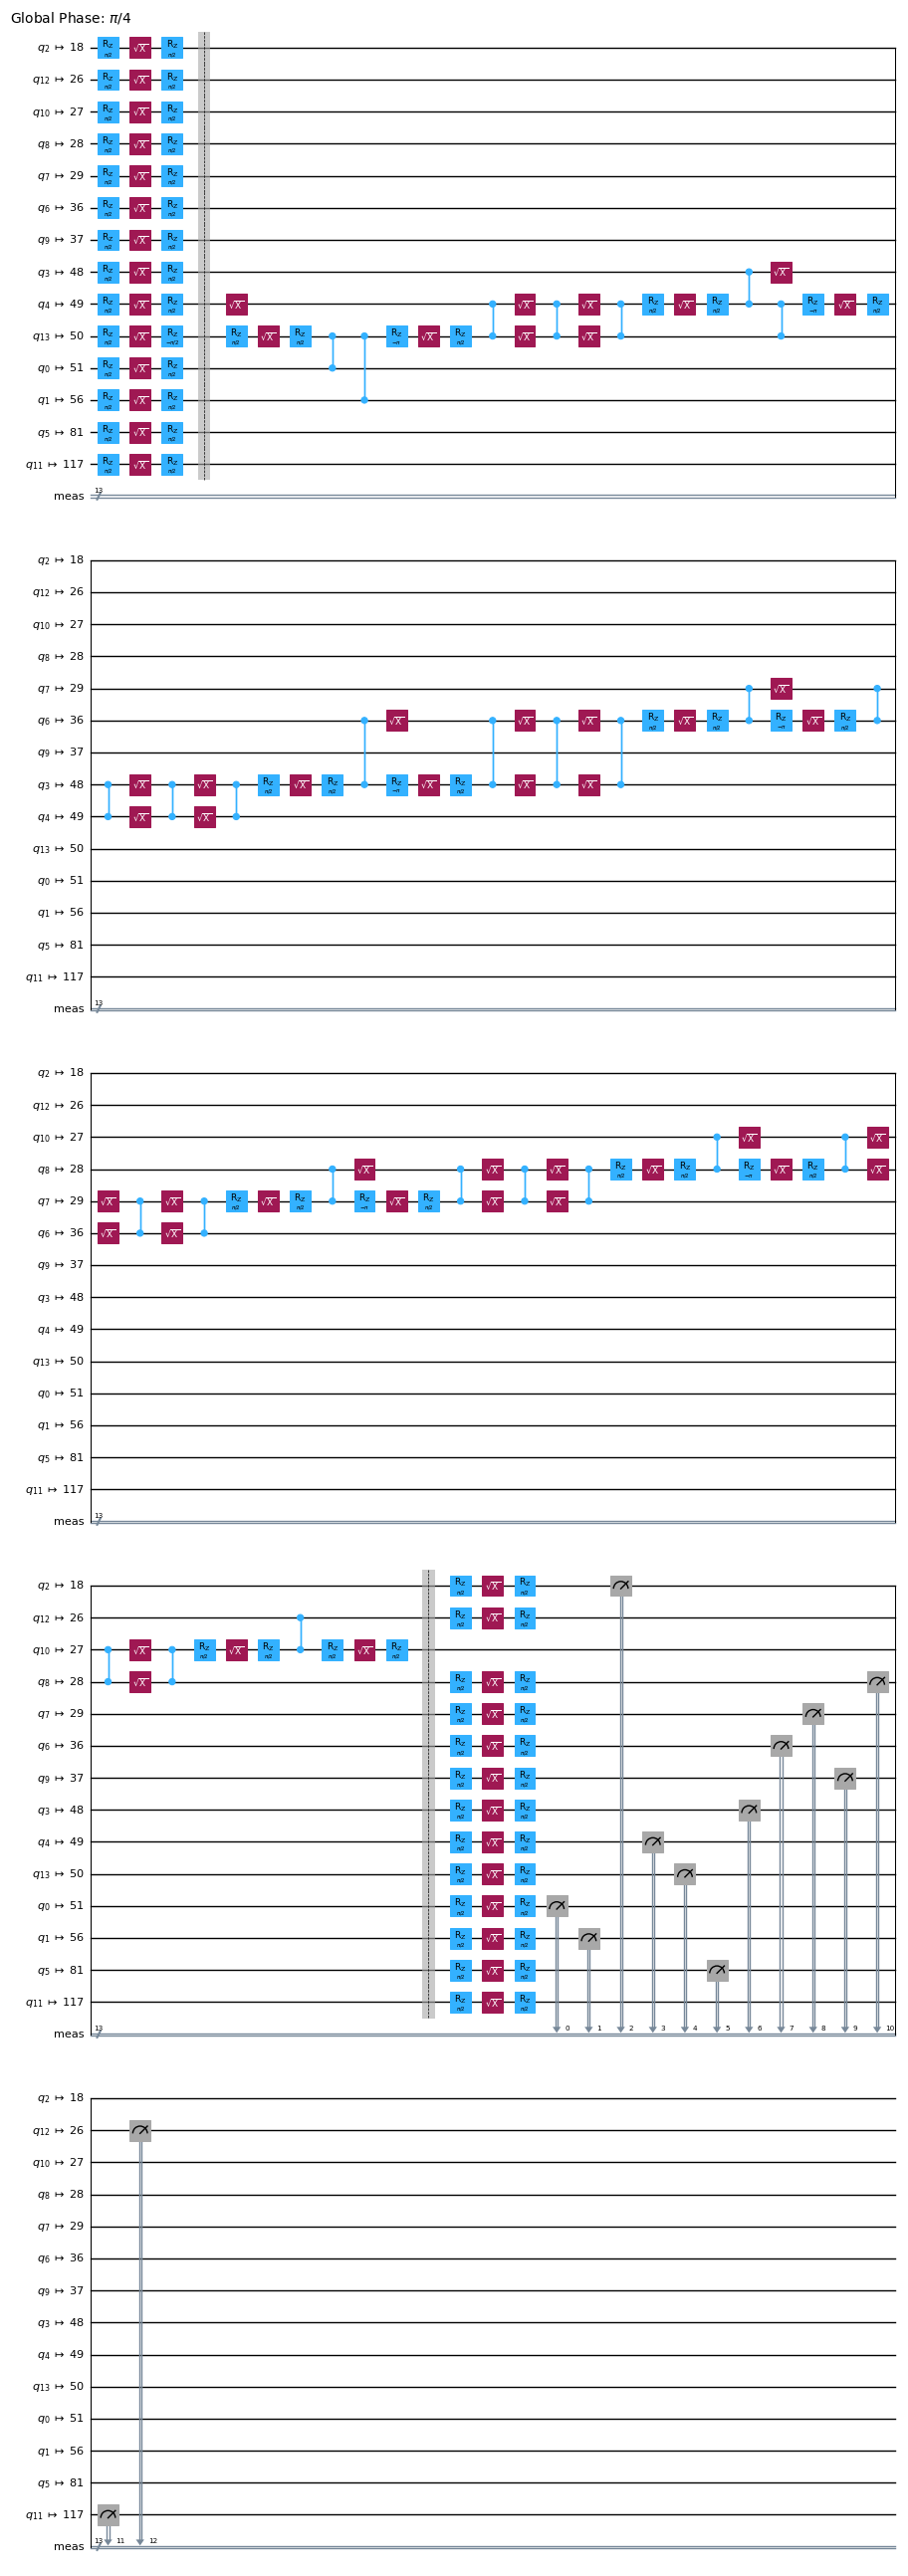

Job ID: d5kdnn2vcahs73a1sdsg

La cadena que más veces obtenemos es 1010111011011, con un 41.70% de probabilidad
La cadena obtenida es correcta


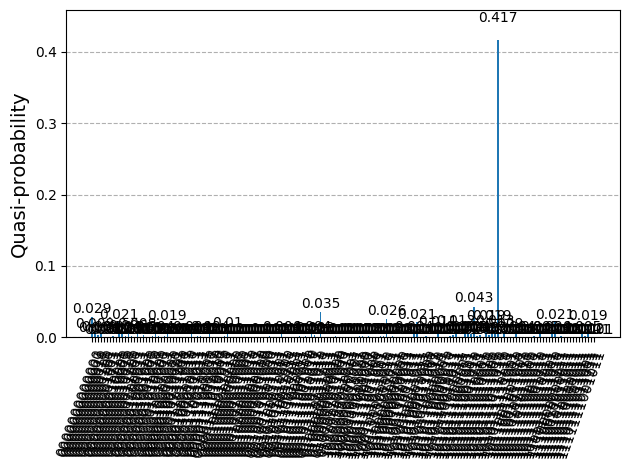

Uso del hardware cuántico: 2 segundos

---------------------------------

Circuito transpilado para el backend ibm_torino:
> Nivel de optimización: 2
> Profundidad: 69
> Número de puertas: OrderedDict({'rz': 74, 'sx': 68, 'cz': 23, 'measure': 13, 'barrier': 2})
> Tiempo de transpilación: 0.03274

Circuito transpilado:


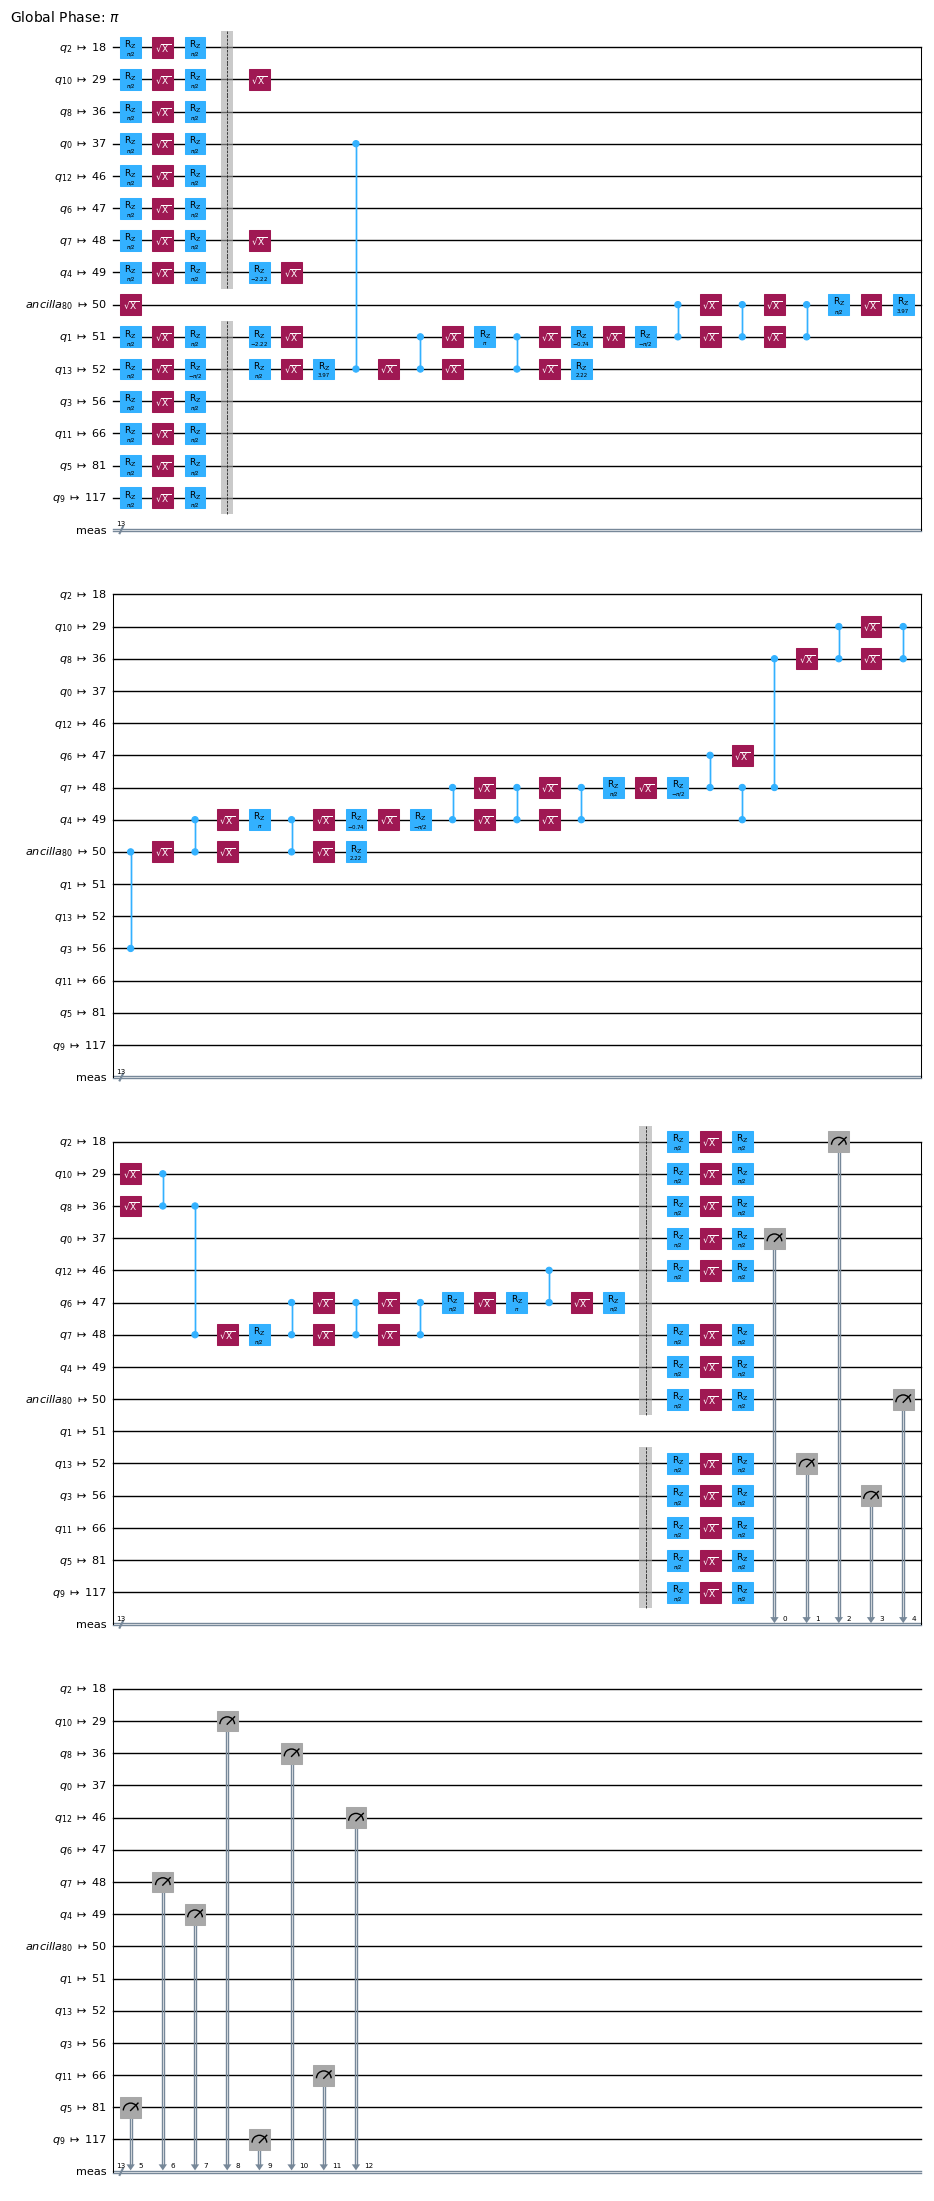

Job ID: d5kdnpavcahs73a1se00

La cadena que más veces obtenemos es 1010111011011, con un 43.00% de probabilidad
La cadena obtenida es correcta


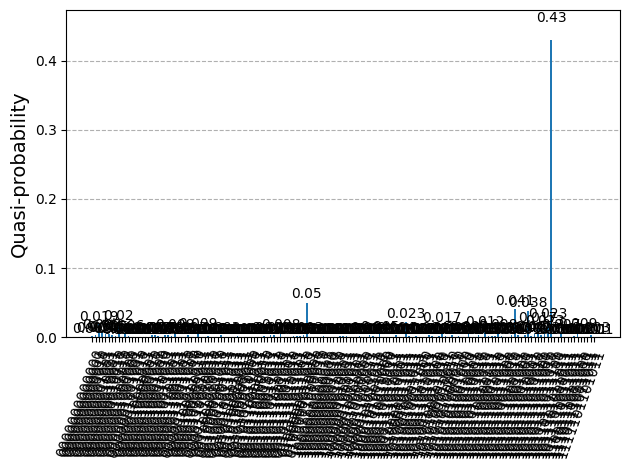

Uso del hardware cuántico: 2 segundos

---------------------------------

Circuito transpilado para el backend ibm_torino:
> Nivel de optimización: 3
> Profundidad: 71
> Número de puertas: OrderedDict({'rz': 72, 'sx': 64, 'cz': 24, 'measure': 13, 'barrier': 2})
> Tiempo de transpilación: 0.03419

Circuito transpilado:


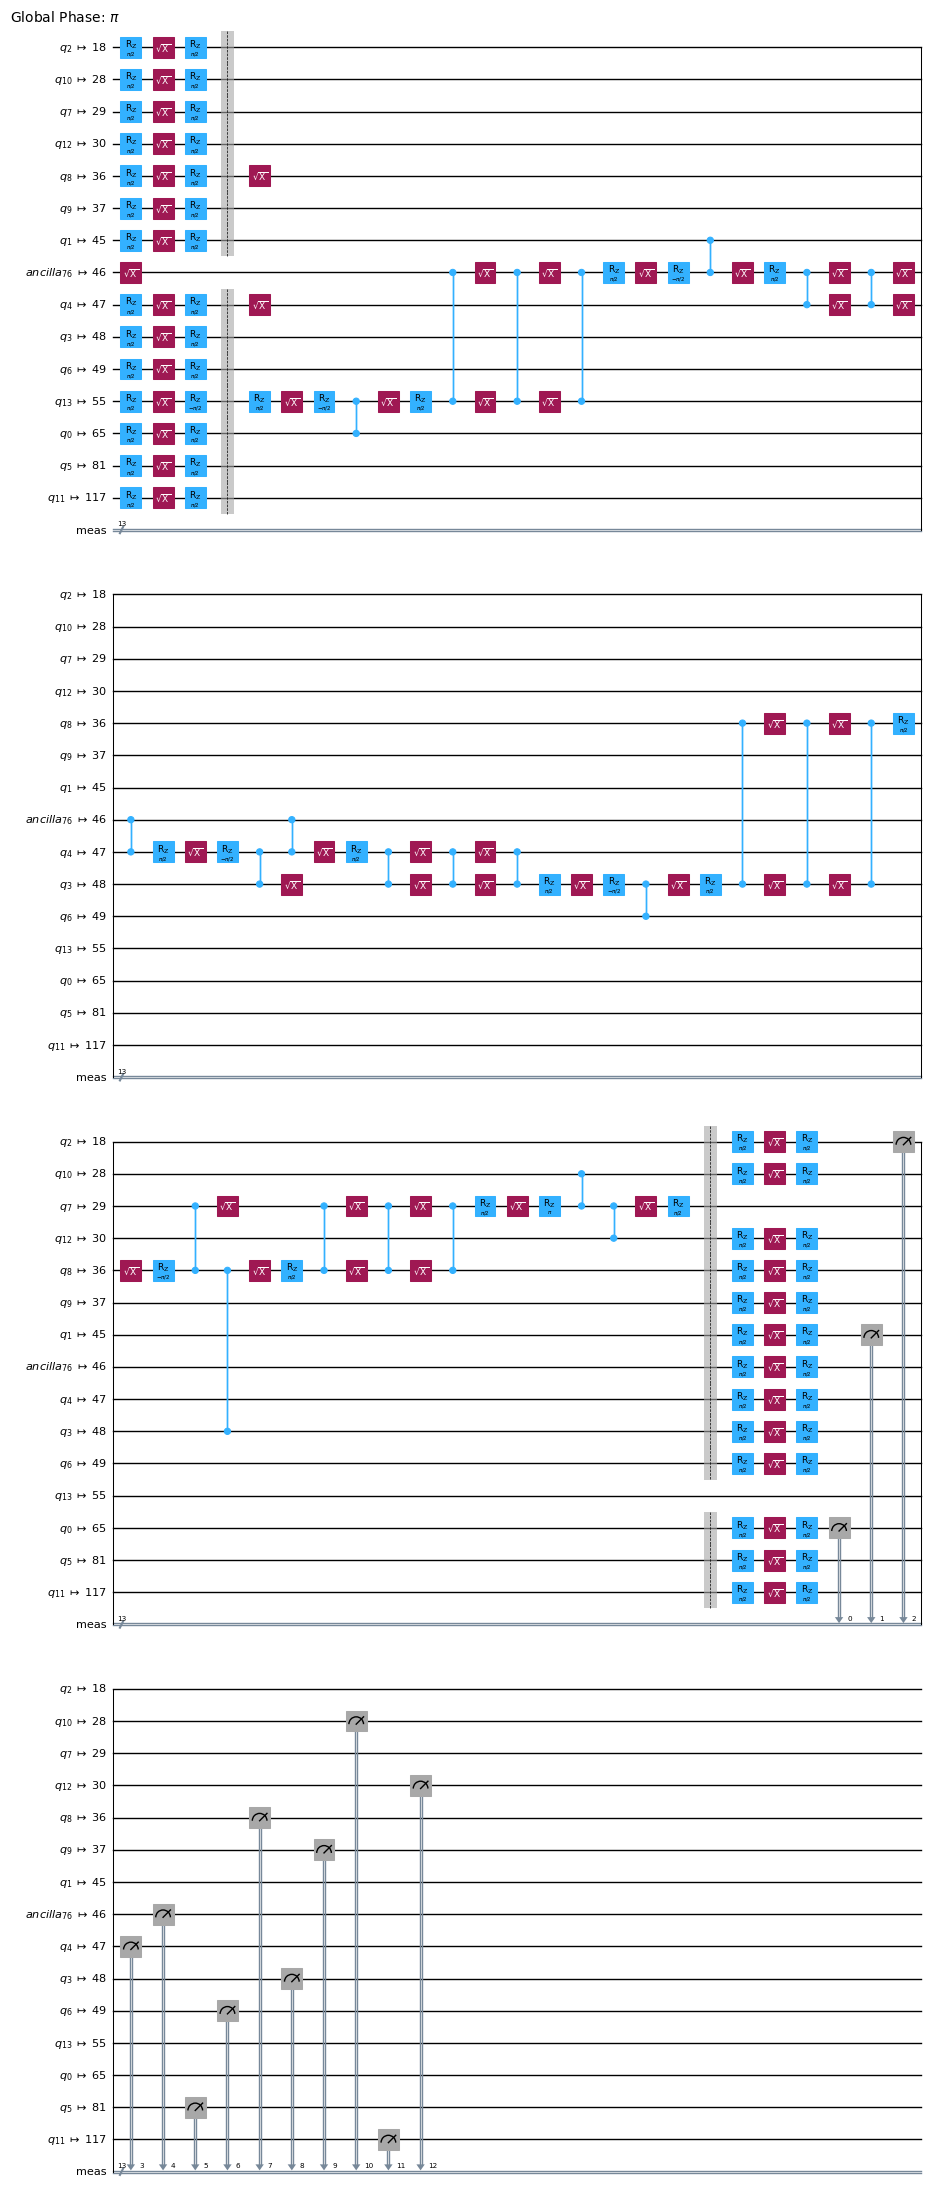

Job ID: d5kdnrbtlojc73f6mkvg

La cadena que más veces obtenemos es 1010111011011, con un 52.30% de probabilidad
La cadena obtenida es correcta


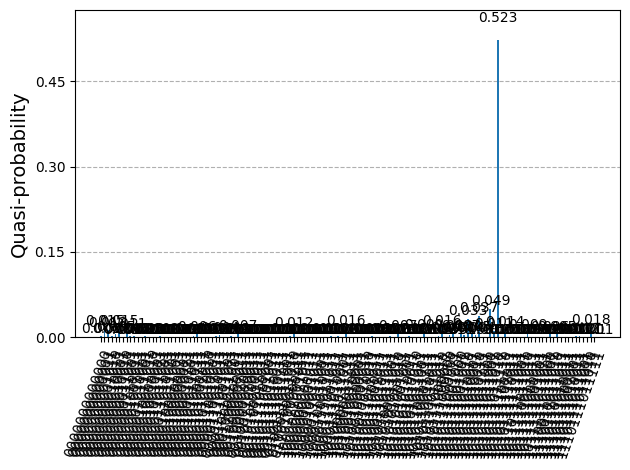

Uso del hardware cuántico: 2 segundos


In [15]:
backend = service.backend("ibm_torino")
execute_all_optimization_levels(qc, backend)

## Aplicar la técnica del circuito espejo

Construimos un circuito compuesto por la ejecución del algoritmo original seguida de su inverso ($U_{total} = U \cdot U^\dagger = I$). En un sistema ideal, el estado final debe ser idéntico al inicial ($| 0 \rangle ^{\otimes n}$). Cualquier desviación el valor esperado ideal cuantifica el ruido introducido por el hardware.

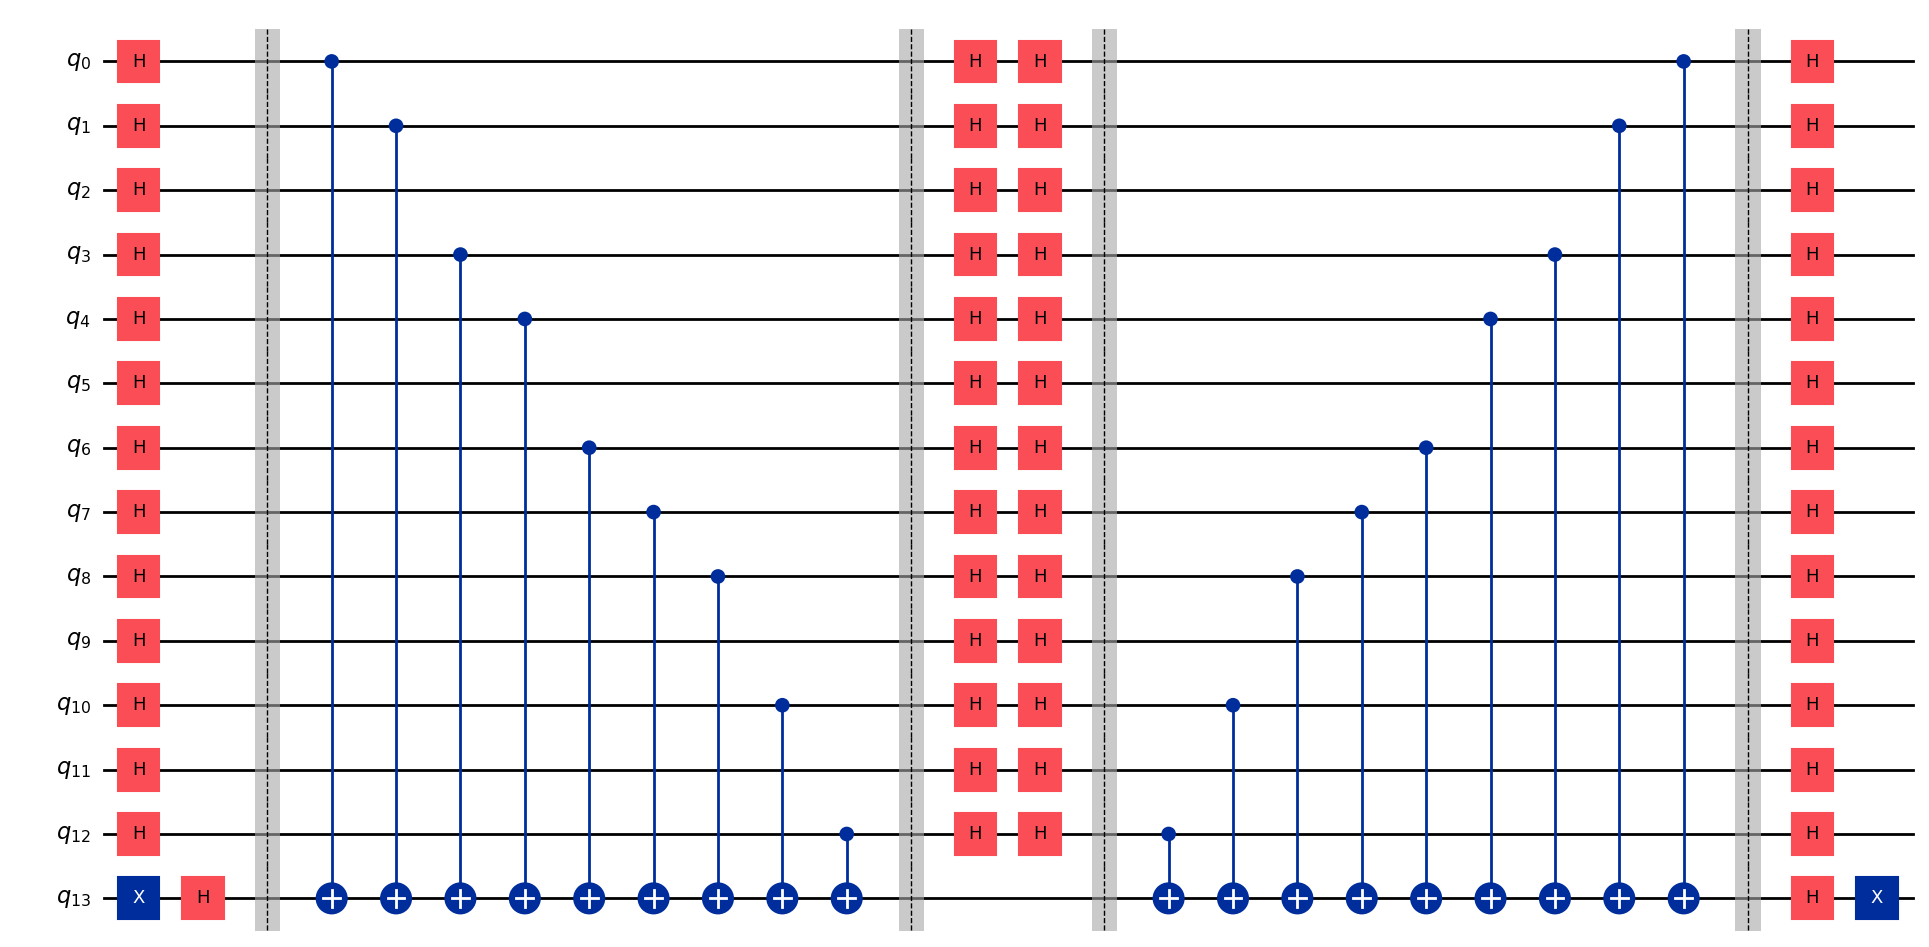

In [16]:
qc_mirror = qc.copy()
qc_mirror.remove_final_measurements()  # eliminar mediciones para mantener unitariedad
qc_mirror.compose(qc_mirror.inverse(), inplace=True)
qc_mirror.draw("mpl", fold=-1)

Comprobamos de manera analítica cuál sería el resultado ideal de medir $\langle 00...0 | Z^{\otimes n} | 00...0 \rangle$:

In [17]:
ideal_state = Statevector.from_instruction(qc_mirror)
observable = SparsePauliOp("Z" * qc_mirror.num_qubits)
analytical_expectation_value = ideal_state.expectation_value(observable)

print(f"Valor esperado analítico (teórico):{analytical_expectation_value.real:.5}")

Valor esperado analítico (teórico):1.0


Transpilamos el circuito para nuestro backend y obtenemos el observable:

In [18]:
backend = service.backend("ibm_torino")
qc_mirror_transpiled = transpile(qc_mirror, backend, optimization_level=2)
observable = SparsePauliOp("Z" * qc_mirror_transpiled.num_qubits)

Probamos ahora los diferentes niveles de resiliencia:

In [19]:
print(f"{'Nivel':<15} | {'Valor Esperado':<15} | {'Error (distancia a 1.0)':<15}")

with Batch(backend=backend) as batch:
    jobs_ids = []
    for resilience_level in (0, 1, 2):
        estimator = Estimator(
            mode=batch, options={"resilience_level": resilience_level}
        )

        job = estimator.run([(qc_mirror_transpiled, observable)])
        jobs_ids.append(job.job_id())

        result = job.result()

        expectation_value = result[0].data.evs
        error = 1.0 - expectation_value

        print(f"{resilience_level:<15} | {expectation_value:<15.5f} | {error:<15.5f}")

    print("\n")

    for i in (0, 1, 2):
        print(f"Job id para nivel de resiliencia {i}: {jobs_ids[i]}")

Nivel           | Valor Esperado  | Error (distancia a 1.0)
0               | -0.02002        | 1.02002        
1               | 0.00293         | 0.99707        
2               | -0.02421        | 1.02421        


Job id para nivel de resiliencia 0: d5kdntsjt3vs73dsbca0
Job id para nivel de resiliencia 1: d5kdnvn853es738dp0t0
Job id para nivel de resiliencia 2: d5kdo4n853es738dp130


Teóricamente, la aplicación de un circuito espejo debería devolver el sistema al estado inicial, dando lugar a un valor esperado del observable igual a 1. Sin embargo, al ejecutarse sobre hardware cuántico real, el circuito espejo incrementa notablemente la profundidad del circuito, lo que provoca una acumulación significativa de errores de decoherencia y de puerta.

Debido a que este error no es unitario (por lo tanto es irreversible), la aplicación del circuito inverso no cancela dichos errores. Como consecuencia, el estado final se aproxima a un estado mezclado, dando lugar a valores esperados cercanos a 0.

Aunque los distintos niveles de resiliencia permiten mitigar ciertos tipos de error, estos no son suficientes para compensar la pérdida de coherencia causada por la elevada profundidad del circuito, por lo que el valor esperado permanece alejado del resultado analítico real.